In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import statsmodels.api as sm
import warnings


# import RFE and Linear Regression for model building
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# for splitting the data between train and test data set
from sklearn.model_selection import train_test_split

# for rescaling the features
from sklearn.preprocessing import MinMaxScaler

# check for VIF values of the feature variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

# to ignore warnings
warnings.filterwarnings('ignore')

### Step 1. Reading, Understanding and Visualizing the data

#### Step 1.a - Reading the data

In [72]:
# reading data in a dataframe
day_df = pd.read_csv('day.csv')

#### Step 1.b Understanding the data

In [73]:
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [74]:
# number of records and features
day_df.shape

(730, 16)

In [75]:
# Checking for null values in day_df
day_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


##### Some observations
   - There are no null values
   - dteday is of object type

In [76]:
# Statistical information about the data
day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


##### Some observations
 - Not all data is on same scale. We will use MinMaxScalar for them.

### EDA - Lets drop features which will not help in prediction due to any reason
 - instant - Its just an index column
 - dteday - We can use this for deriving year or month but we already have them as other columns
 - casual and registered - they will cause data leakage as they will not be available for at the time of prediction    
    -  Also the error in predicting casual and registered will be more than the count (cnt).

In [77]:
features_to_be_dropped = ['instant', 'dteday', 'casual', 'registered'] 
day_df.drop(features_to_be_dropped, axis=1, inplace=True)

In [78]:
day_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [79]:
day_df.shape

(730, 12)

In [80]:
# There are some features which are actually categorical but they look continuous
# For categorical its better to use boxplot to better visualize 
# Lets put lables for them - season, mnth, weekday, weathersit
day_df['season'] = day_df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
day_df['mnth'] = day_df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'june',
                                      7:'july', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})
day_df['weekday'] = day_df['weekday'].map({0:'sun', 1:'mon', 2:'tue', 3:'wed', 
                                           4:'thu', 5:'fri', 6:'sat'})                       
day_df['weathersit']= day_df['weathersit'].map({1:'Clear', 2:'Misty', 
                                                3:'Light_Snow', 
                                                4:'Heavy_Rain'})

In [81]:
day_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


#### Step 1.c Visulaizing the data

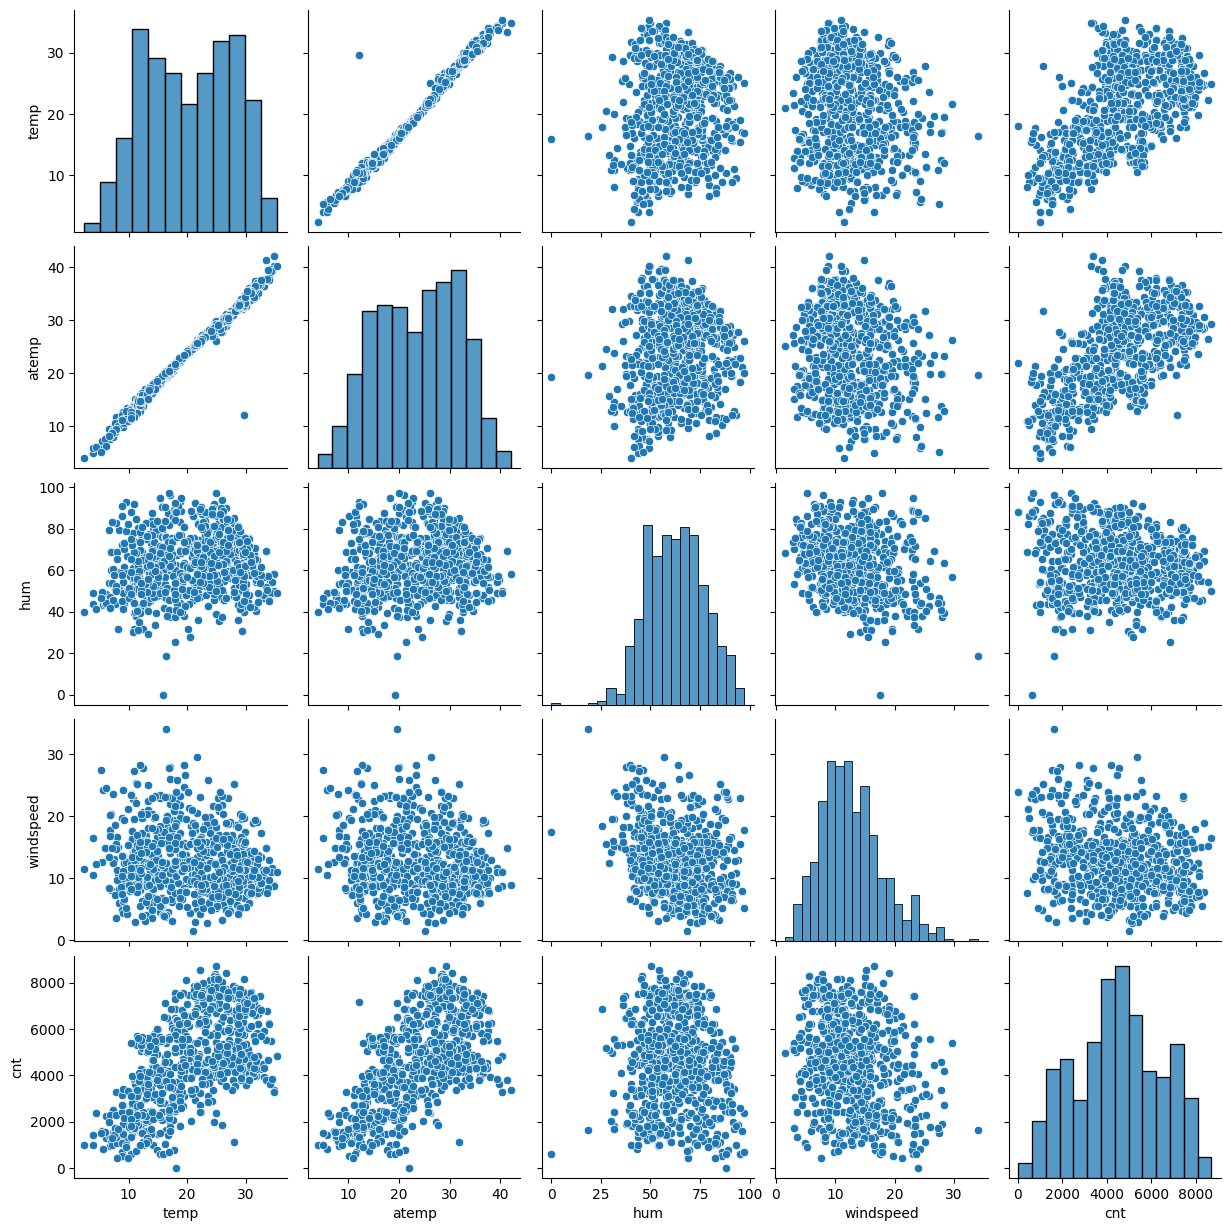

In [82]:
# First we want to know if in current case Linear regression makes sense or not.
# Here cnt should be lineary related to some of the variables.
# Lets create scatter plot and look for linearity, if we don't find any, then no point of doing Linear regression.

# For continuous variables 
# We will create scatter plot for pair of numerical variables. 
continuous_variables = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(day_df[continuous_variables])
plt.show()

## Some Observations
 - From above pairplot variables like temp and atemp are lineraly related to cnt. So linear regression makes sense here.
 - temp and atemp looks to be higly correlated with each other.

In [83]:
# For categorical variables 
# Lets visualize the categorical variable using boxplot

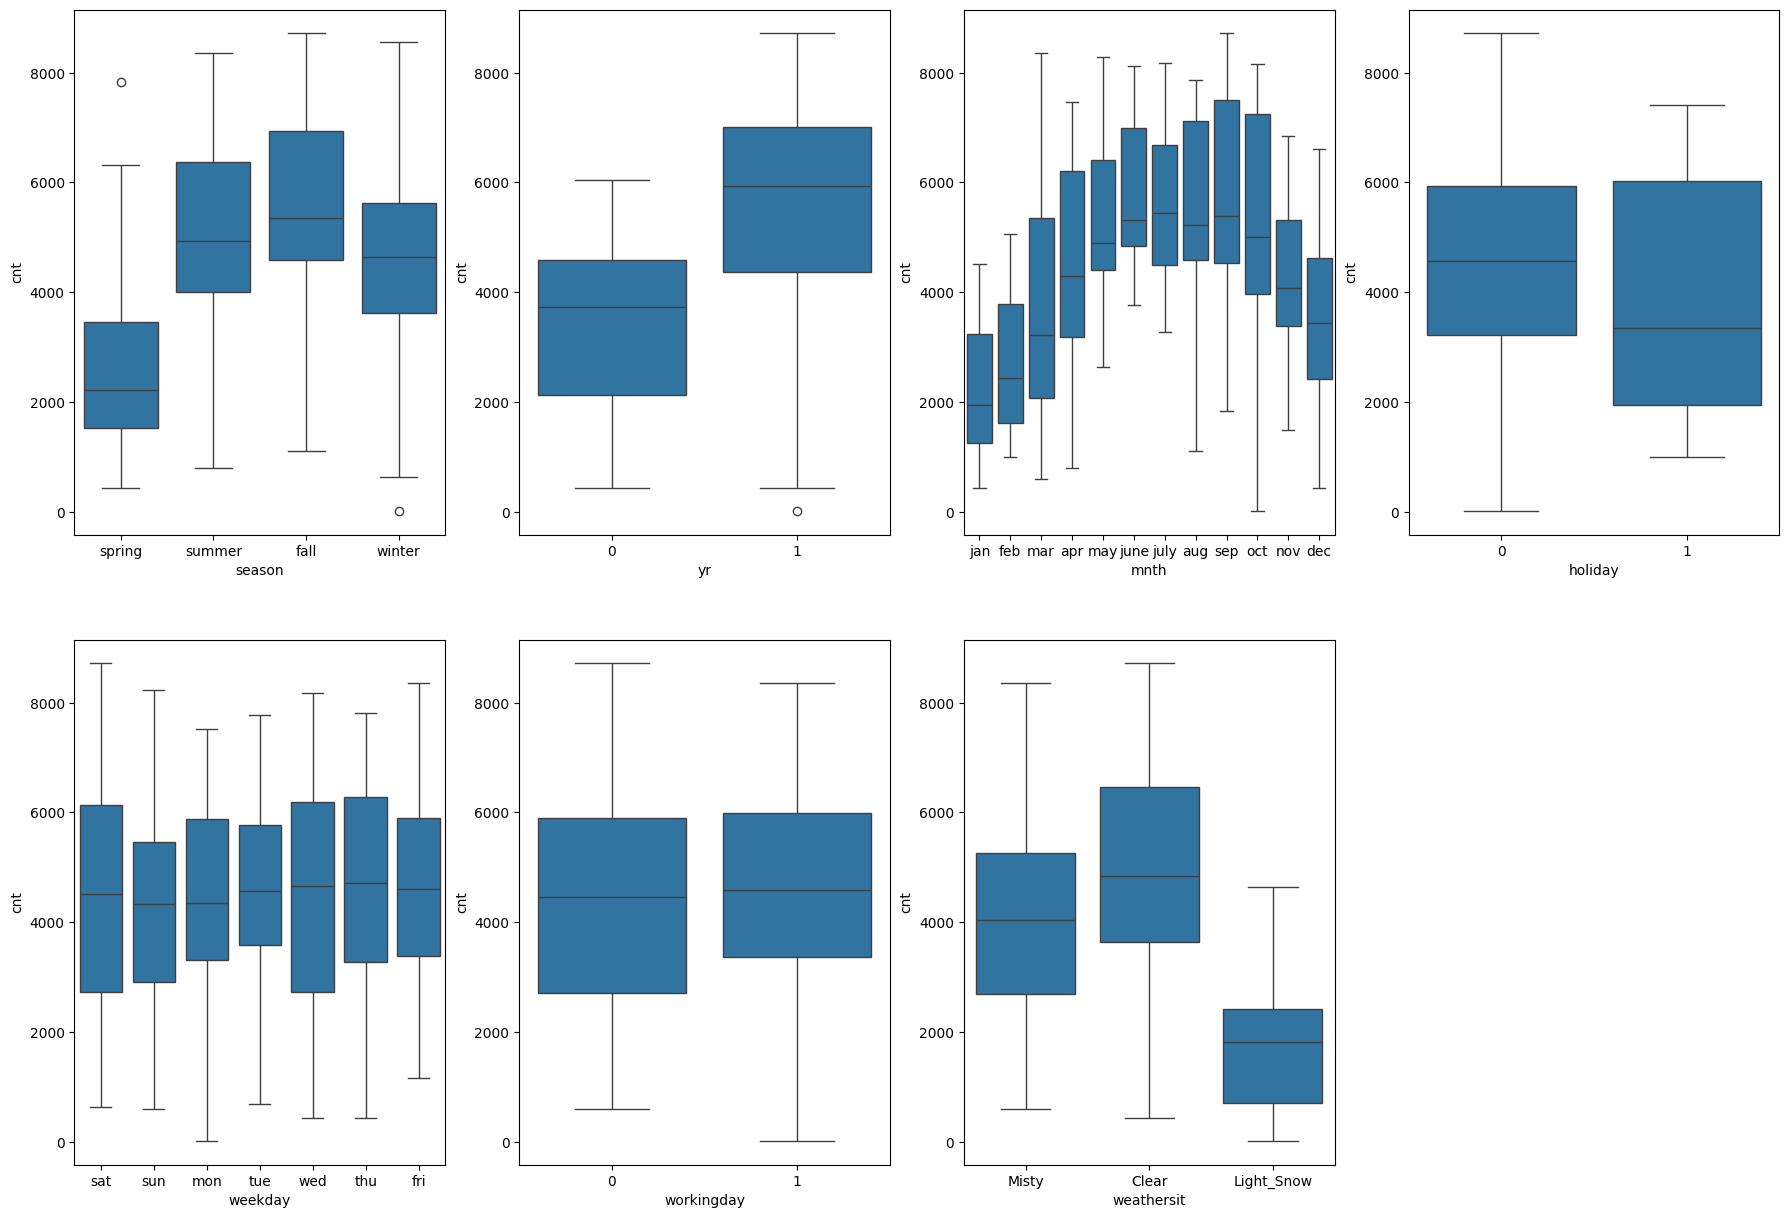

In [84]:
# Lets have a subplot for this as there are many categorical variables.
plt.figure(figsize=(22,15))
plt.subplot(2,4,1)
sns.boxplot(x='season', y='cnt', data=day_df)
plt.subplot(2, 4, 2)
sns.boxplot(x='yr', y='cnt', data=day_df)
plt.subplot(2, 4, 3)
sns.boxplot(x='mnth', y='cnt', data=day_df)
plt.subplot(2, 4, 4)
sns.boxplot(x='holiday', y='cnt', data=day_df)
plt.subplot(2, 4, 5)
sns.boxplot(x='weekday', y='cnt', data=day_df)
plt.subplot(2, 4, 6)
sns.boxplot(x='workingday', y='cnt', data=day_df)
plt.subplot(2, 4, 7)
sns.boxplot(x='weathersit', y='cnt', data=day_df)
plt.show()

## Some Observations
   - Fall season has higher count(cnt) followed by summer season.
   - There is a significant rise in count(cnt) from 2018 (0) to 1 (2019).
   - count(cnt) increases from jan till oct and then we see a drop in nov and dec months.
   - days doesn't seems to affect the cnt much (though sat and wed looks to be having higher cnt)
   - When wheather is clear then count(cnt) is higher and when its Light_Snow its drastically low.
   - Also we don't see any outliers

### Step 2. Preparing the data for modelling (train-test split, rescaling etc.)

We will follow

    2.A Encoding
        Convert binary categorical variable to 0 and 1
        Convert other categorical varible to dummy variables
    2.B Splitting dataset into Train and Test sets
    2.C Rescaling of the variables

In [85]:
# Lets look at the data once
day_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


#### 2.A Encoding
    - Convert binary categorical variable to 0 and 1
    - Convert other categorical varible to dummy variables

In [86]:
day_df['yr'].value_counts()

yr
0    365
1    365
Name: count, dtype: int64

In [87]:
day_df['holiday'].value_counts()

holiday
0    709
1     21
Name: count, dtype: int64

In [88]:
day_df['workingday'].value_counts()

workingday
1    499
0    231
Name: count, dtype: int64

ERROR! Session/line number was not unique in database. History logging moved to new session 5


#### Observation - yr, holiday and workingday are already either 0 or 1. So nothing to do for them.

#### For other categorical variables we will need dummy variables

In [89]:
seasons_dummy_var = pd.get_dummies(day_df['season'], dtype='int', drop_first=True)
seasons_dummy_var.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [90]:
# Lets do the same for other variables too
months_dummy_var = pd.get_dummies(day_df['mnth'] , dtype='int', drop_first=True)
weekdays_dummy_var = pd.get_dummies(day_df['weekday'], dtype='int', drop_first=True)
weathersit_dummy_var = pd.get_dummies(day_df['weathersit'], dtype='int', drop_first=True)

In [91]:
# Now concat the dummy dataframe with the original one
day_df = pd.concat([day_df, seasons_dummy_var, months_dummy_var, 
                    weekdays_dummy_var, weathersit_dummy_var], axis=1)
day_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [92]:
day_df.shape

(730, 34)

In [93]:
# We should drop not needed columns now - season, mnth, weekday & weathersit
day_df = day_df.drop(['season', 'mnth', 'weekday', 'weathersit'], axis=1)
day_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [94]:
day_df.shape

(730, 30)

### 2.B Splitting into Train and Test

In [95]:
# Lets have 70% data for train and 30% for test
df_train, df_test = train_test_split(day_df, train_size=0.7, random_state=100)

In [96]:
df_train.shape

(510, 30)

In [97]:
df_test.shape

(220, 30)

In [98]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
111,0,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [99]:
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
184,0,1,0,29.793347,33.27085,63.7917,5.459106,6043,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
535,1,0,1,32.082500,36.04875,59.2083,7.625404,6211,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
299,0,0,1,19.270000,22.85230,81.2917,13.250121,2659,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
221,0,0,1,31.433347,34.24915,42.4167,13.417286,4780,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
152,0,0,1,29.315000,32.19710,30.5000,19.583229,4968,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


### 2.C Rescaling of the variables
  - Not all numerical variables are on the same scale. so lets rescale them. Not considering variables which are either derived or have values between 0 and 1.
  - Lets use Min-Max scaling (Normalization) --> compresses all the data between 0 and 1

In [100]:
# create MinMaxScaler object
scaler = MinMaxScaler()

# continuous_variables = ['temp', 'atemp', 'hum', 'windspeed', 'cnt'] --> It holds the numerical variables.

# fit and transform the data
df_train[continuous_variables] = scaler.fit_transform(df_train[continuous_variables])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [101]:
# we can see now all variables are between 0 and 1.

In [102]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,july,june,mar,may,nov,oct,sep,mon,sat,sun,thu,tue,wed,Light_Snow,Misty
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,0.096078,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,0.294988,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
# Also max is 1 in all cases after scaling.

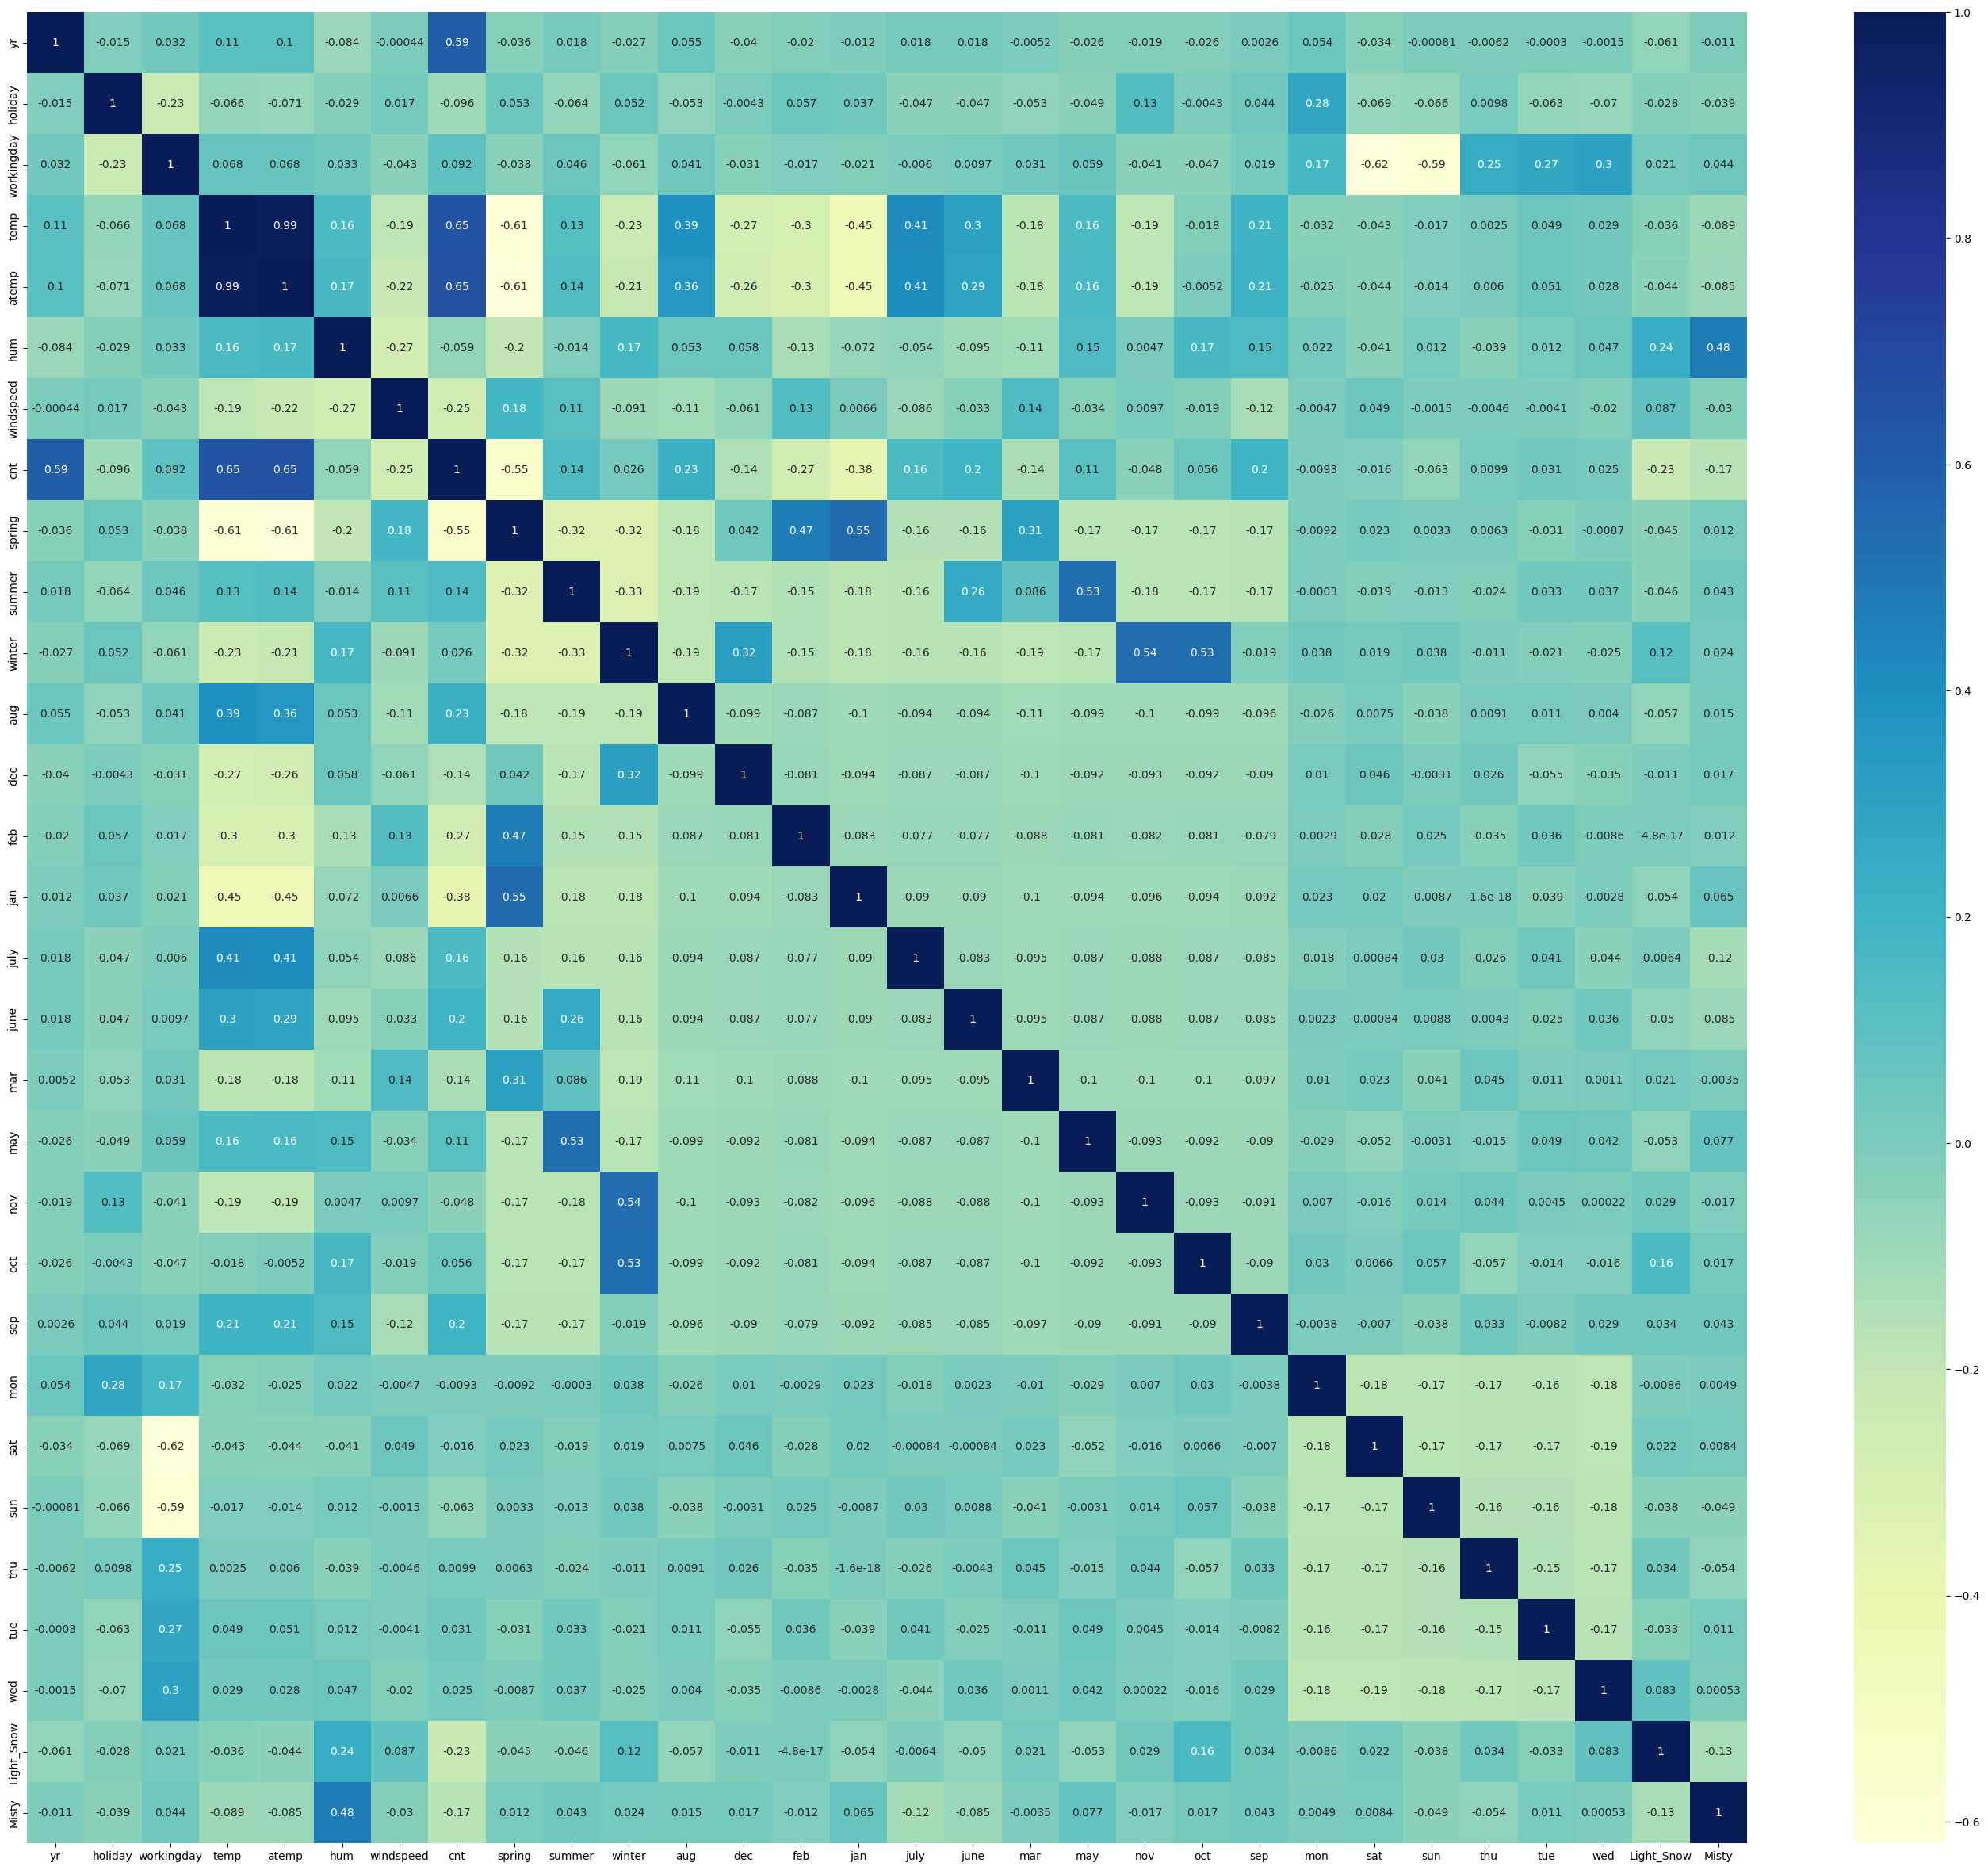

In [104]:
# Lets create a heatmap to see which variables are most co-related with count(cnt)
plt.figure(figsize=(35,30))
sns.heatmap(df_train.corr(), annot=True, cmap='YlGnBu')
plt.show()